# Imports

In [1]:
import os
import sys
sys.path.insert(0, os.environ.get('SRC_FIGMA_PATH'))

import resources.context as c # First import because it's not object oriented
from cryptocurrencyetl import CryptocurrencyEtl
from resources.dataanalysis import DataAnalysis
from resources.dataanalysis import DataTransform
from resources.timeseriesmodeling import TimeSeriesModeling

# 1.0. Data Extraction

In [2]:
# extract any cryptocurrency historical data to analysis
crypto = 'BTC'
market_curr = 'USD'
api_key = os.environ.get('TOKEN_FIGMA_CRYPTO_KEY')

crypt_etl = CryptocurrencyEtl(crypto=crypto, market_curr=market_curr, api_key=api_key)

#crypt_etl.test_market_curr()
#crypt_etl.test_crypto()

df_btc_usd = crypt_etl.run()

CryptoETL || 2022-06-26 21:55:23,553 (INFO) || Initing extract of ETL to obtain BTC historical data in USD value!
CryptoETL || 2022-06-26 21:55:24,710 (INFO) || Initing data transform of BTC historical data!
CryptoETL || 2022-06-26 21:55:24,726 (INFO) || ETL finished!


In [3]:
# use standard dataset to test notebook's code
#df_test = pd.read_csv(c.DATA_INT_FLD / 'test_df.csv')

# 2.0. Data Analysis

In [4]:
analy = DataAnalysis(df_btc_usd, date_col='timestamp', individual_figsize=(18, 8), start_date='2021-01-01')

## Adfuller Description

In [5]:
txt_path = c.FIG_FLD / 'crypto_analysis/adffuller_description.txt'
analy.adfuller_description(y='close', saving_txtloc=txt_path)

1. ADF : -1.6346603949380045
2. P-Value : 0.46505223160751746
3. Num Of Lags : 0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 542
5. Critical Values :
	1%: -3.442472769145813
	5%: -2.8668873212324817
	10%: -2.5696179384812297



## Statistical Description

In [6]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_statistical_description_test.png'
analy.statistical_description(saving_figloc=fig_path)

[0626/215525.520042:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0626/215525.620058:INFO:headless_shell.cc(653)] Written to file /tmp/tmpyqc7t0v8/temp.png.


,attributes,mean,median,std,min,max,range,skew,kurtosis
0,open,44051.235893,43071.660000,10155.717989,18970.79000,67525.820000,48555.030000,0.102131,-0.569820
1,high,45314.866611,44141.370000,10310.606630,20792.06000,69000.000000,48207.940000,0.080644,-0.563988
2,low,42567.397790,42000.300000,10009.525533,17622.00000,66222.400000,48600.400000,0.100022,-0.570475
3,close,44037.022762,43071.660000,10182.903810,18970.79000,67525.830000,48555.040000,0.090412,-0.556316
4,volume,65792.247989,55235.028032,38892.992722,1830.47123,354347.243161,352516.771931,2.363771,9.127982


## Seasonal Decomposition

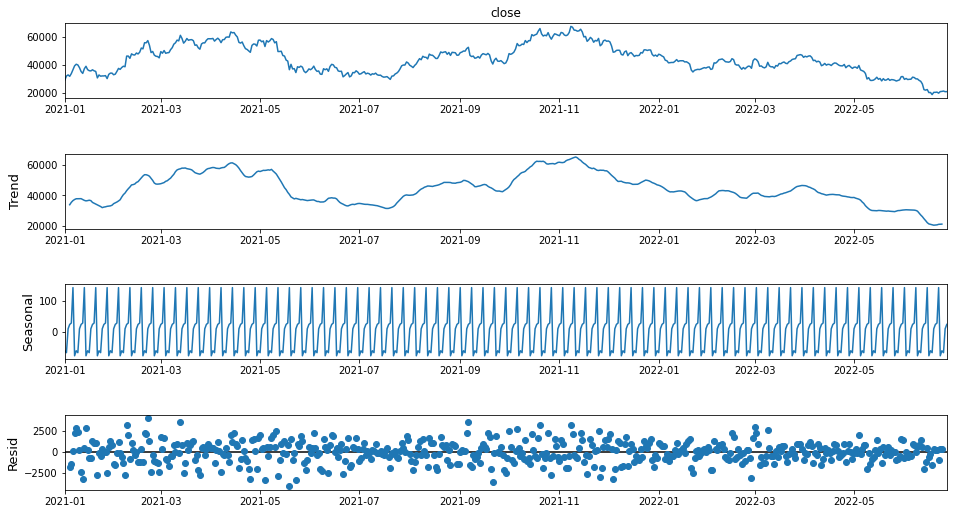

In [7]:
fig_path = c.FIG_FLD / 'crypto_analysis/seasonal_decomposer.jpg'
analy.plot_seasonal_decomposer(y='close', saving_figloc=fig_path, all_inches=(15, 8))

## Temporal Estability

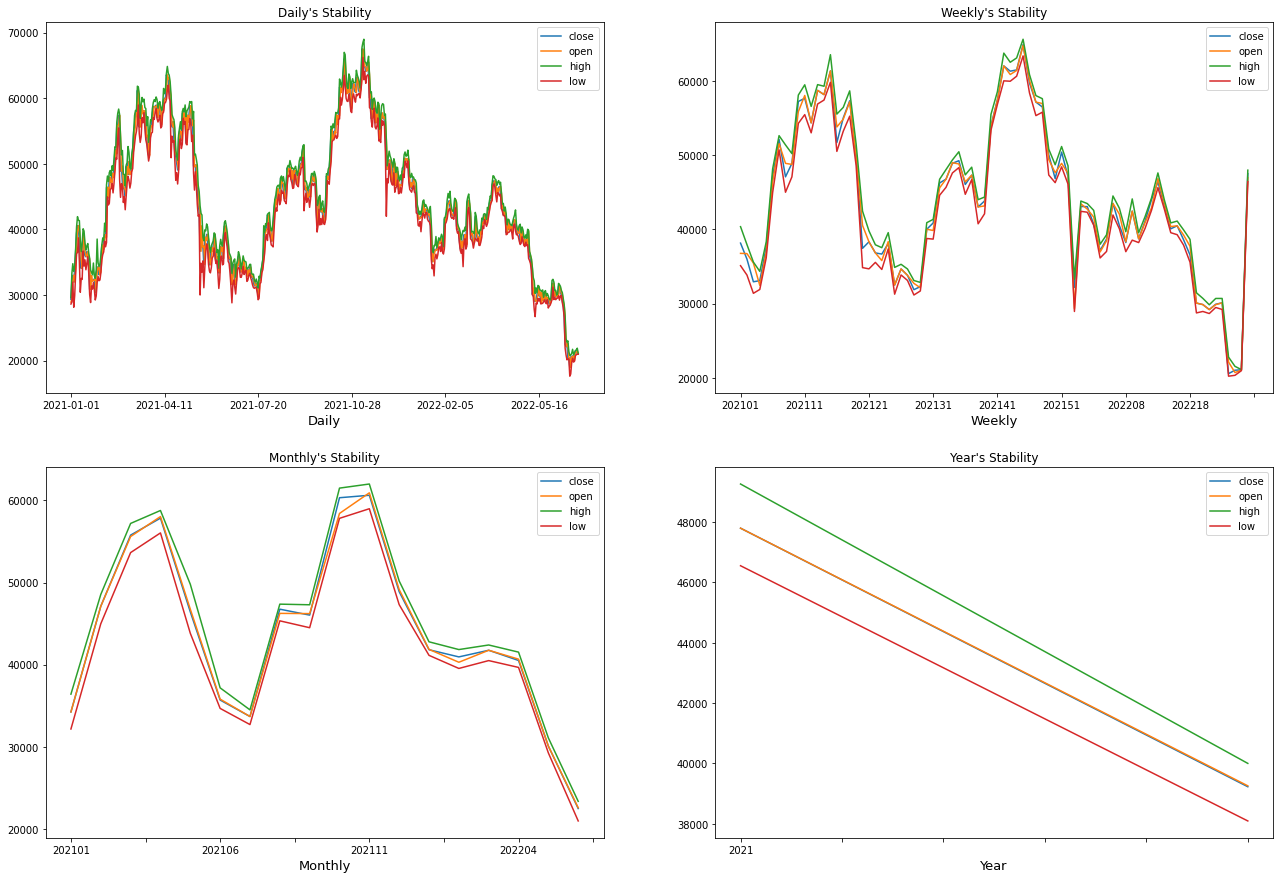

In [8]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_stability_all.jpg'
analy.all_timely_stability(y=['close', 'open', 'high', 'low'], saving_figloc=fig_path)

## Outlier Identification

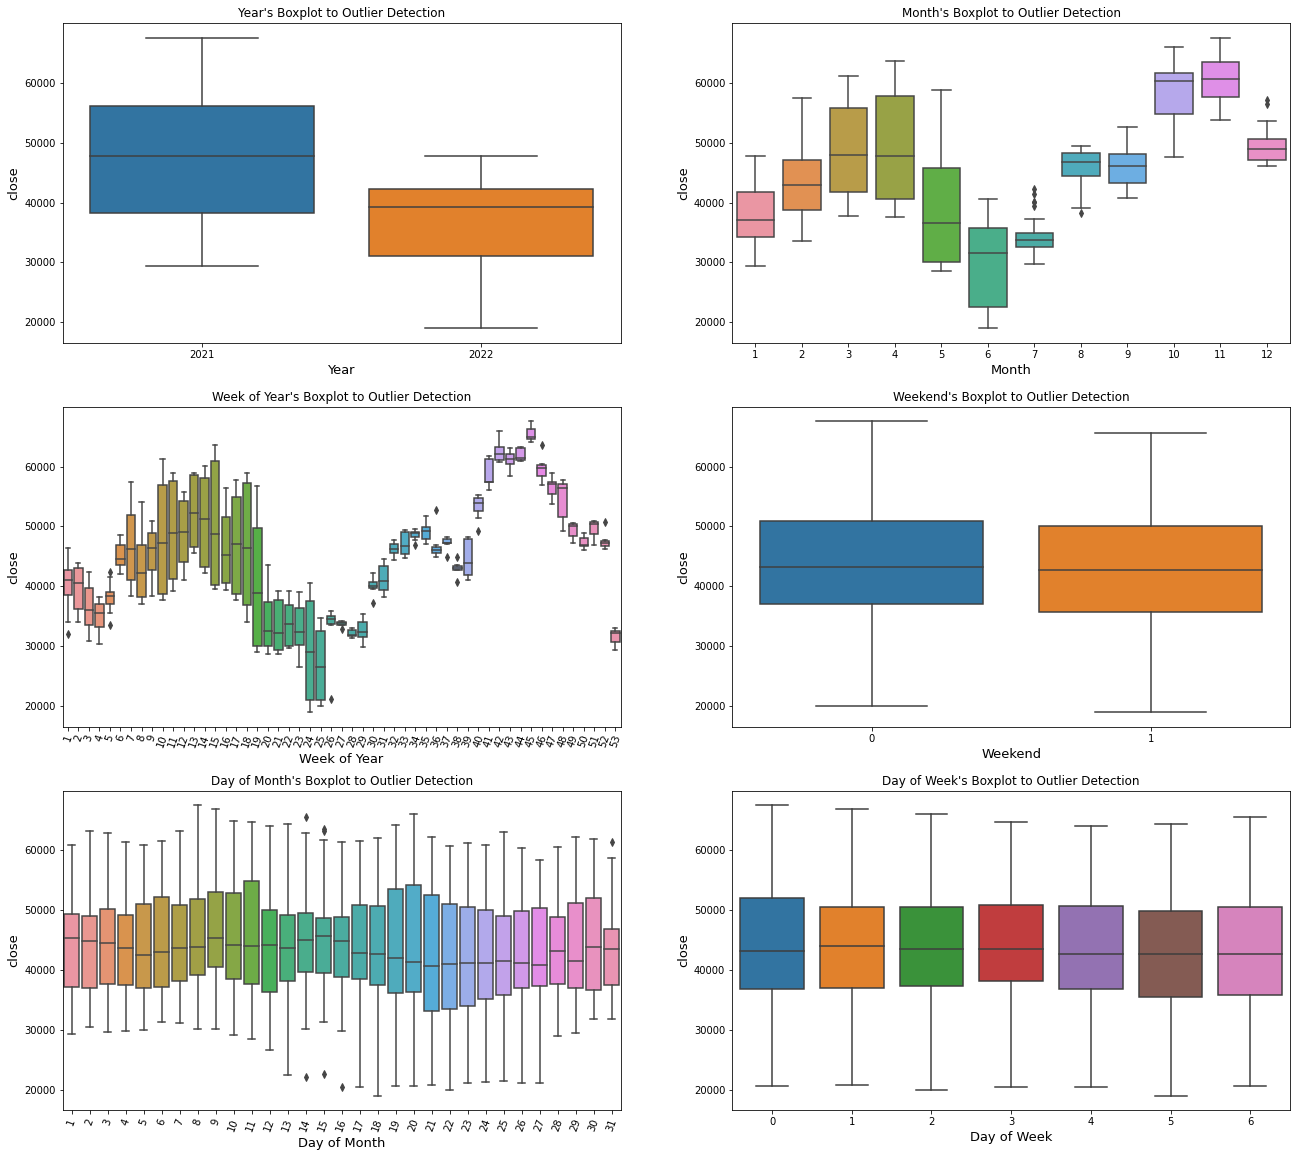

In [9]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_outlier_detector_all.jpg'
analy.all_temporal_outlier_detector_boxplots(y='close', saving_figloc=fig_path)

## Distribution

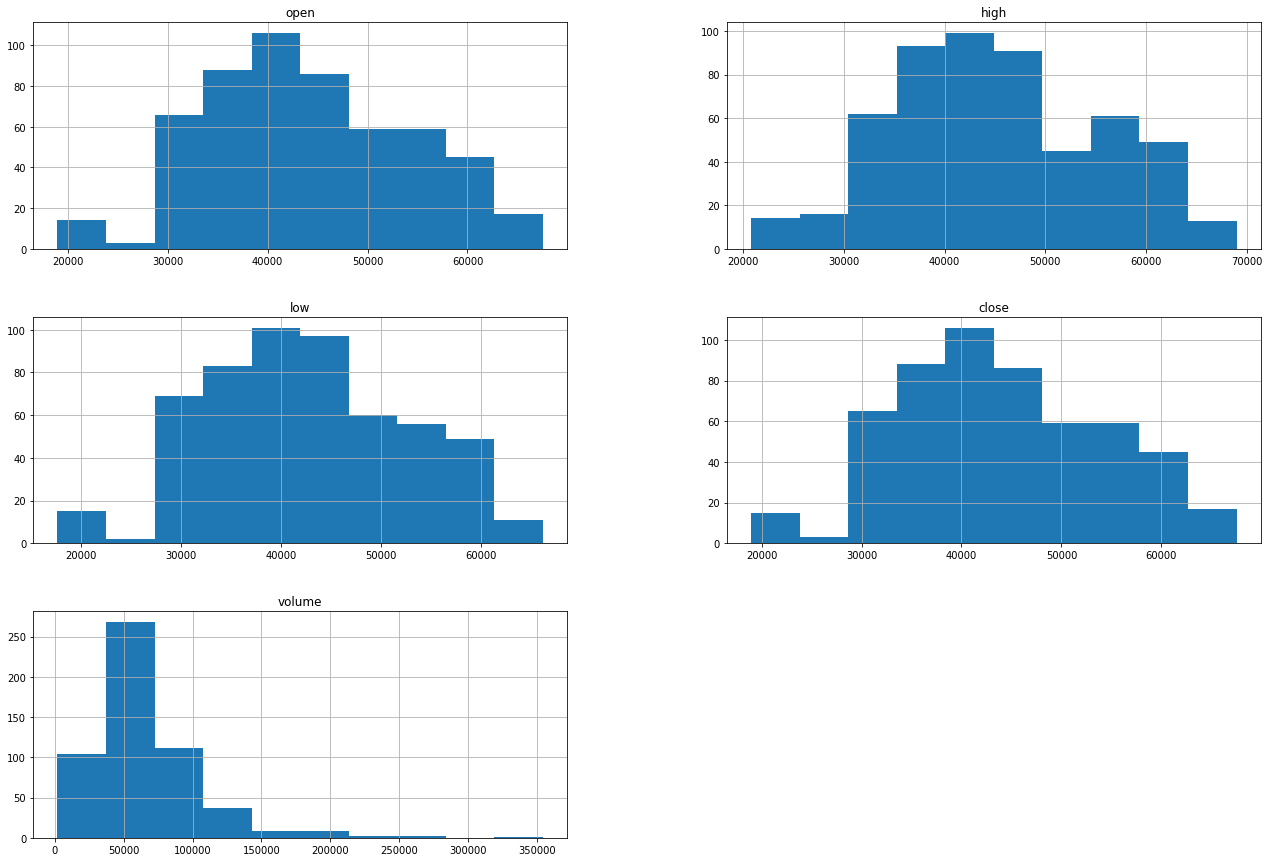

In [10]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_distribution_check.jpg'
analy.distribution_check(saving_figloc=fig_path)

## Nature Transformation Effect

DataAnaly || 2022-06-26 21:55:31,362 (WARNING) || The mean difference in log1p transformation 
                                         is below 0.01! (difference = 5.3598214469122845e-14)
DataAnaly || 2022-06-26 21:55:31,406 (WARNING) || The mean difference in yeo-johnson transformation 
                                         is below 0.01! (difference = 9.80177347104084e-12)


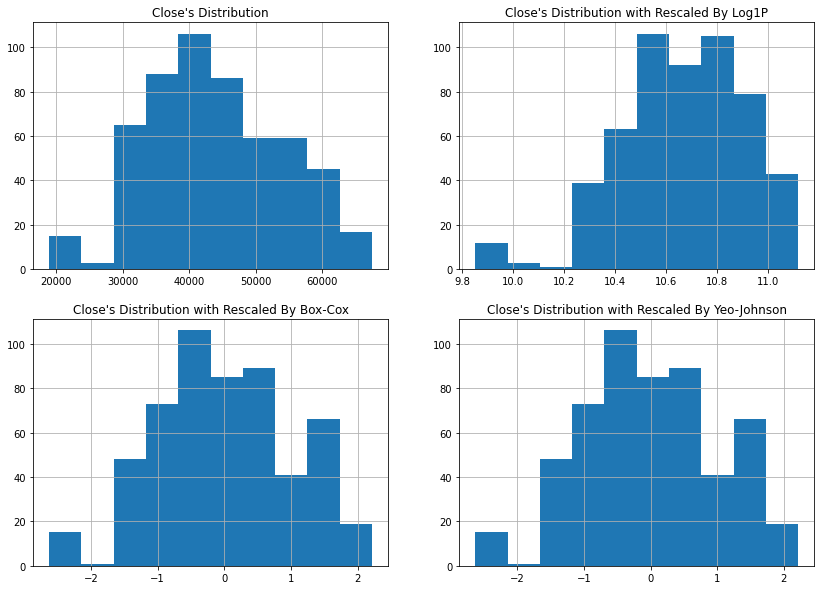

In [11]:
fig_path = c.FIG_FLD / 'crypto_analysis/btc_nature_transformation_check.jpg'
analy.rescalling_effect_check(y='close', all_figsize=(14, 10), saving_figloc=fig_path)

# 3.0. Data Preparation

In [12]:
transforming_df = DataTransform(df=df_btc_usd, date_col='timestamp', start_date='2022-01-01')
df_prep, scaler = transforming_df.prepare_dataframe_timeseries(y='close', method='log1p')

DataTrans || 2022-06-26 21:55:32,483 (WARNING) || The mean difference in log1p transformation 
                                         is below 0.01! (difference = 1.4798557859356121e-12)


# 4.0. Machine Learning Model

## 4.1. Model Fit and Forescast

In [14]:
ts_model = TimeSeriesModeling(df=df_prep)
model = ts_model.fit_sarimax()

In [20]:
df_result = ts_model.forecast(next_days=15)

## 4.2. Data Translation

### Returning to real scaler

In [27]:
reverse_df = DataTransform(df=df_result, start_date='2022-01-01')
df_common = reverse_df.inverse_transformation(df=df_result, y_nt='log1p_close', col_orig_name='close', scaler=scaler)
df_common = reverse_df.inverse_transformation(df=df_common, y_nt='log1p_close_forecast', col_orig_name='close_forecast', scaler=scaler)

### Analysing Results

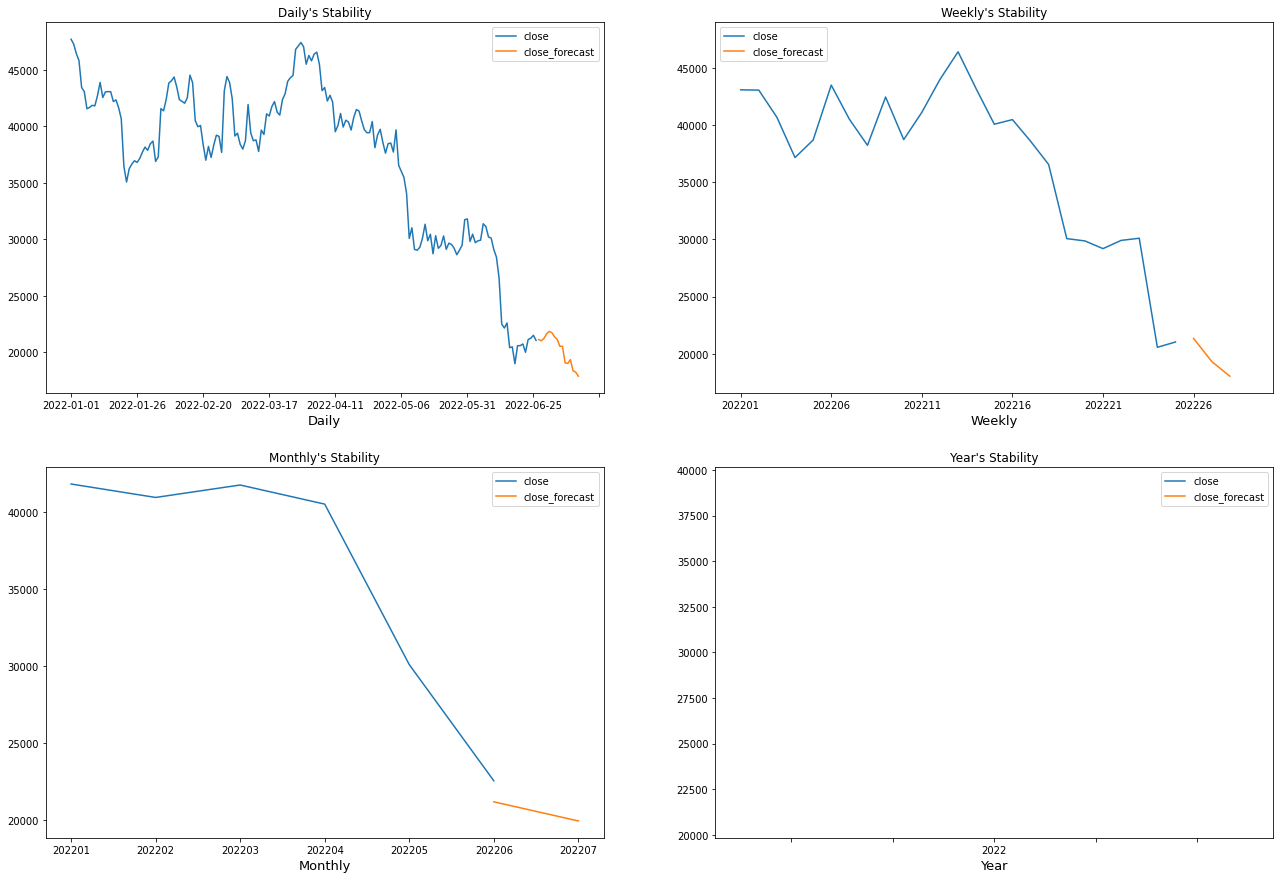

In [30]:
analy = DataAnalysis(df_common, individual_figsize=(18, 10), start_date='2022-01-01')
fig_path = c.FIG_FLD / 'crypto_analysis/model_forecast.jpg'
analy.all_timely_stability(y=['close', 'close_forecast'], saving_figloc=fig_path)